In [2]:
import glob
import os
import random
from skimage import exposure
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# import keras library
import keras

import glob
# import Sequential from the keras models module
from keras.models import Sequential

# import Dense, Dropout, Flatten, Conv2D, MaxPooling2D from the keras layers module
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
D_PATH = '../tensorflow_model/data/'

In [3]:
import tensorflow as tf
# Assemble training and test data from @TrainingData files
data_file = sorted(glob.glob(f'{D_PATH}/*.npy'))

training_dicts=[]
for file in data_file:

    training_files= np.load(file,allow_pickle=True)

    training_dicts.append(training_files[()])
images = []
targets = []
for dict_ in training_dicts:
    # print(dict_)
    for j in range(len(dict_['target'])):
        if dict_['data'][j].shape == (41, 41,3):
            resized_image = tf.image.resize(dict_['data'][j], size=(32, 32), method=tf.image.ResizeMethod.BILINEAR)

            images.append(resized_image)
            targets.append(dict_['target'][j])
if len(images) == len(targets):
#
    X = np.array(images)
#
#     # X= X[:,:,:,np.newaxis]
#     X = np.concatenate((X, X, X), axis=-1)
    y = np.array(targets)
    print (f"The Dataset contains {len(X)} images")
else:
    print ("Images and Targets dont match, check the training data!")


The Dataset contains 5973 images


In [4]:
y.tolist().count(1)

965

In [5]:
def plot_digits(sample, images_per_row=5, **options):
    # Get the shape of the individual images
    img_shape = sample[0].shape
    height, width = img_shape[:2]
    # Calculate the number of rows needed to display all the images
    n_rows = (len(sample) - 1) // images_per_row + 1
    # Calculate the number of empty image slots needed to complete the last row
    n_empty = n_rows * images_per_row - len(sample)
    # Create a batch of processed images to display
    images = []
    for image in sample:
        percentiles = np.percentile(image, (1, 99))
        scaled=exposure.rescale_intensity(image, in_range=tuple(percentiles))
        # plt.imshow(scaled)
        # plt.show()
        scaled[:,:,0]=np.zeros((41, 41))
        images.append(scaled)
    # Add empty images to the batch to complete the last row
    images.append(np.zeros((height, width * n_empty)))
    # Concatenate the images in each row
    row_images = []
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]

        row_images.append(np.concatenate(rimages, axis=1))
    # Concatenate the rows to create the final image
    image = np.concatenate(row_images, axis=0)
    # # Display the final image
    plt.imshow(image, **options)
    plt.axis("off")
    plt.show()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_test.shape


(598, 32, 32, 3)

In [8]:
# # initialize standard scaler
# ss = StandardScaler()
#
# def scale_features(train_features, test_features):
#     for image in train_features:
#         # for each channel, apply standard scaler's fit_transform method
#         for channel in range(image.shape[2]):
#             image[:, :, channel] = ss.fit_transform(image[:, :, channel])
#     for image in test_features:
#         # for each channel, apply standard scaler's transform method
#         for channel in range(image.shape[2]):
#             image[:, :, channel] = ss.transform(image[:, :, channel])
#
#
# # apply scale_features to four sets of features
# scale_features(X_train, X_test)


In [6]:
# define model as Sequential
model = Sequential()
# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=[32,32,3]))
# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(2,2)))
# add a second 2D convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# add dropout to prevent over fitting
model.add(Dropout(0.5))
# add a thirs 2D convolutional layer with 128 filters
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# add dropout to prevent over fitting
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
# fully connected layer
model.add(Dense(64, activation='relu'))
# add additional dropout to prevent overfitting
model.add(Dropout(0.5))
# prediction layers
model.add(Dense(1, activation='sigmoid', name='preds'))
# show model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 13, 13, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 128)         147584    
                                                        

In [7]:
# Compile the model
model.compile(
    # set the loss as binary_crossentropy
    loss='binary_crossentropy',
    # set the optimizer as stochastic gradient descent
    optimizer='adam',
    # set the metric as accuracy
    metrics=['accuracy']
)

In [8]:
# mock-train the model using the first ten observations of the train and test sets
history=model.fit(
    X_train,
    y_train,
    epochs=50,
    verbose=1,
    validation_split=0.2)

Epoch 1/50


2023-03-24 10:59:37.030747: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


135/135 [==============================] - 4s 28ms/step - loss: 0.3598 - accuracy: 0.8523 - val_loss: 0.2844 - val_accuracy: 0.8679
Epoch 2/50
135/135 [==============================] - 4s 26ms/step - loss: 0.2417 - accuracy: 0.8944 - val_loss: 0.2111 - val_accuracy: 0.9265
Epoch 3/50
135/135 [==============================] - 4s 32ms/step - loss: 0.1884 - accuracy: 0.9300 - val_loss: 0.1633 - val_accuracy: 0.9414
Epoch 4/50
135/135 [==============================] - 4s 26ms/step - loss: 0.1810 - accuracy: 0.9402 - val_loss: 0.1470 - val_accuracy: 0.9442
Epoch 5/50
135/135 [==============================] - 3s 26ms/step - loss: 0.1561 - accuracy: 0.9430 - val_loss: 0.1554 - val_accuracy: 0.9470
Epoch 6/50
135/135 [==============================] - 4s 27ms/step - loss: 0.1646 - accuracy: 0.9405 - val_loss: 0.1333 - val_accuracy: 0.9488
Epoch 7/50
135/135 [==============================] - 3s 26ms/step - loss: 0.1513 - accuracy: 0.9484 - val_loss: 0.1326 - val_accuracy: 0.9516
Epoch 8/50

In [9]:
model.evaluate(X_test,y_test)


19/19 [==============================] - 0s 9ms/step - loss: 0.1799 - accuracy: 0.9515


[0.17991040647029877, 0.9515050053596497]

In [10]:
y_proba=model.predict(X_test)

print("First five probabilities:")
print(y_proba[:10])
print("")

# predicted classes for x_eval
y_pred= np.round(y_proba).astype('int')

print("First five class predictions:")
print(y_pred[:10])
print("")

First five probabilities:
[[1.0689323e-05]
 [1.6337633e-04]
 [9.9999982e-01]
 [7.0288777e-02]
 [1.3366108e-06]
 [1.4860417e-08]
 [3.2763285e-08]
 [9.9999982e-01]
 [9.9999952e-01]
 [9.9999595e-01]]

First five class predictions:
[[0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]]



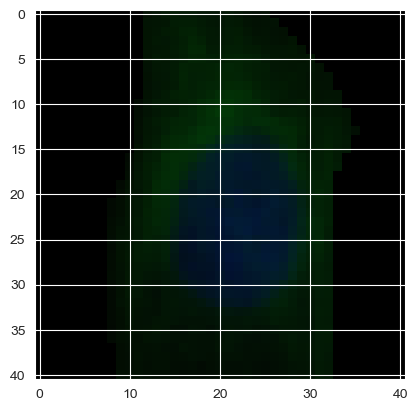

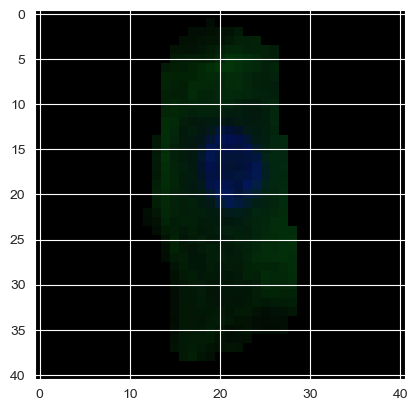

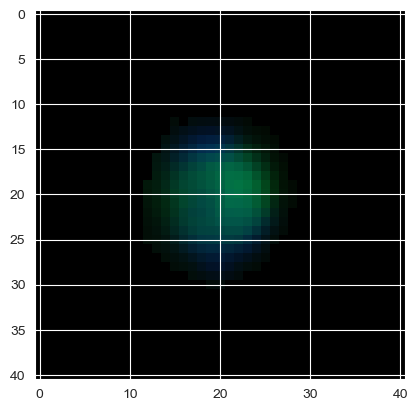

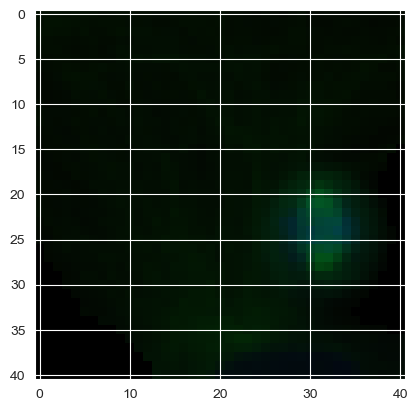

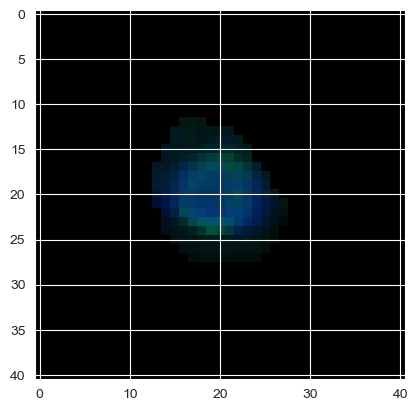

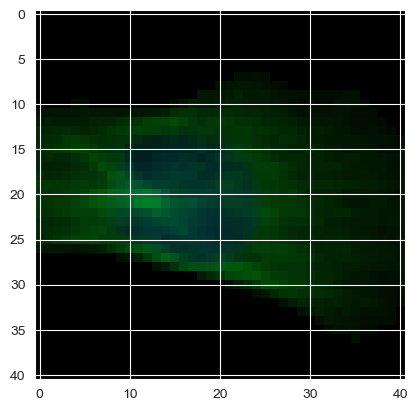

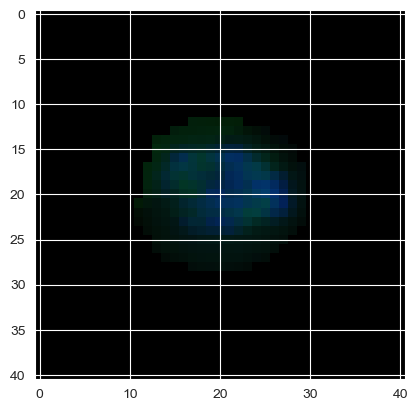

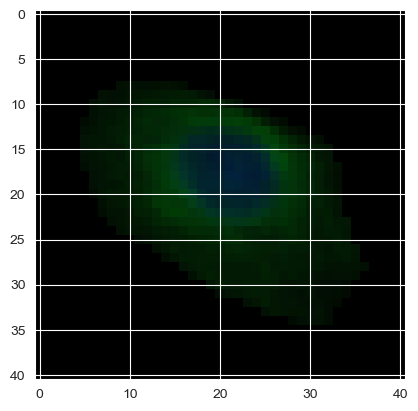

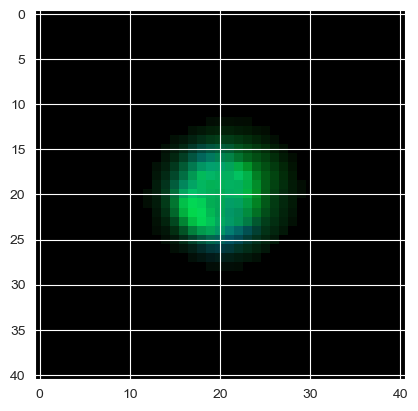

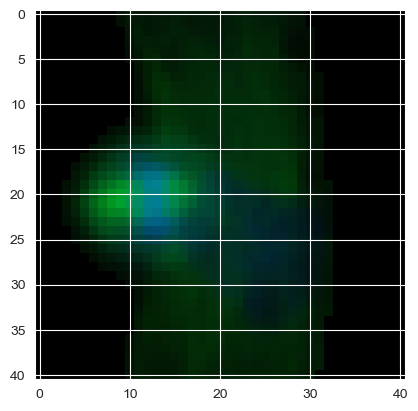

In [9]:
for i in range (10):
    plt.imshow(X_test[i], cmap='gray')
    plt.show(block=False)

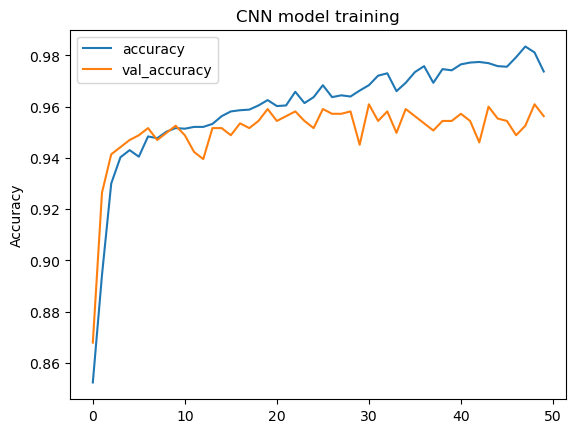

In [10]:
# Extract the history from the training object
training = history.history

# Plot the training loss
plt.plot(training['accuracy'],label='accuracy')
# Plot the validation loss
plt.plot(training['val_accuracy'],label='val_accuracy')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN model training')
# save_fig('training_data')
# Show the figure
plt.show()

In [11]:
model.save(os.path.join('../tensorflow_h5/MI_CNN_model_0324.h5'))

In [14]:
model1=keras.models.load_model(os.path.join('../tensorflow_h5/MI_CNN_model_0301.h5'))

In [12]:
model.evaluate(X_test,y_test)

19/19 [==============================] - 0s 10ms/step - loss: 0.1799 - accuracy: 0.9515


[0.17991040647029877, 0.9515050053596497]

In [13]:
y_proba=model.predict(X_test)
y_pred= np.round(y_proba).astype('int')

In [14]:
y_proba=model.predict(X)

y_pred= np.round(y_proba).astype('int')
y_pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

                   pred_inter  pred_1
ground_true_inter        4965      43
ground_true_M              86     879


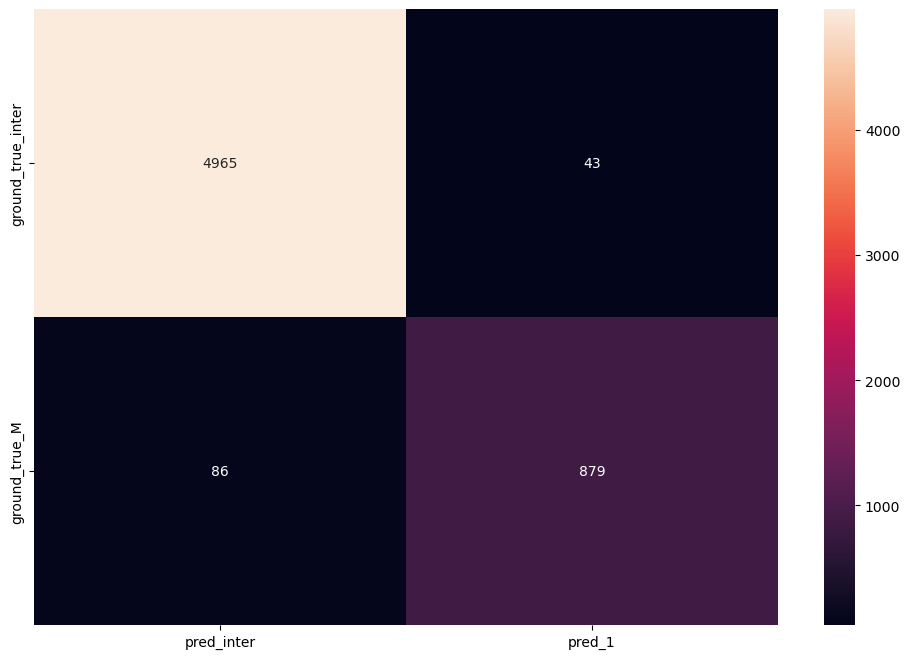

In [15]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns


def df_confusion(label,pred):
    """
    transfer confusion matrix to data frame
    :param label: ground truth label
    :param pred: predicted label
    :return: DataFrame
    """

    df=pd.DataFrame(confusion_matrix(label, pred,labels=[0,1]),columns=['pred_inter','pred_1'],index=['ground_true_inter','ground_true_M'])
    print(df)
    fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))
    sns.heatmap(df, annot=True, fmt='g', ax=axs)
    plt.show()
df_confusion(label=y ,pred=y_pred)
